In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import kpss
from scipy.signal import welch
from pmdarima.arima import ARIMA
from pmdarima.datasets import load_airpassengers
from pmdarima.model_selection import train_test_split
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
import warnings
warnings.filterwarnings("ignore")

data=pd.read_csv('LargeCorn2.csv')
data

,date,value
0,1/2/80,2.8650
1,1/3/80,2.8650
2,1/4/80,2.8425
3,1/9/80,2.7425
4,1/10/80,2.6525
...,...,...
11172,3/22/24,NaN
11173,3/23/24,NaN
11174,3/24/24,NaN
11175,3/25/24,NaN


In [2]:
data.isna().sum()

data.dropna(inplace=True)

In [3]:
print(data.columns)

Index(['date', 'value'], dtype='object')


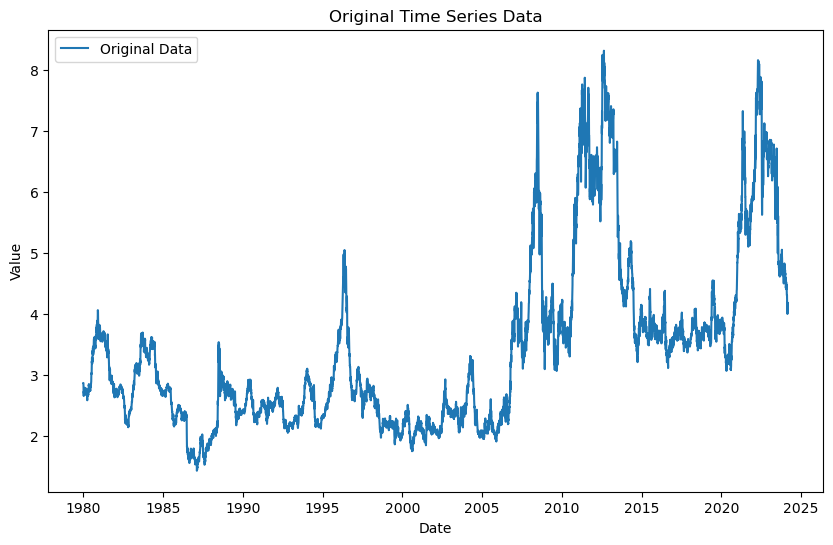

In [4]:
# Assuming 'data' is your DataFrame with the column names as printed
# Example data:
# data = pd.DataFrame({'date': ['7/1/59', '8/15/70', '9/30/70'],
#                      'value': [10, 20, 30]})

# Remove extra space from column name
data.columns = data.columns.str.strip()

# Preprocess 'date' column to handle two-digit year issue
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Define a function to handle year replacement
def replace_year(date):
    if date.year >= 0 and date.year <= 24:
        return date.replace(year=date.year + 2000)
    elif date.year >= 59 and date.year <= 99:
        return date.replace(year=date.year + 1900)
    else:
        return date

# Adjust two-digit years to four-digit years based on the condition
data['date'] = data['date'].apply(replace_year)

# Set 'date' column as index
data.set_index('date', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['value'], label='Original Data')
plt.title('Original Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [5]:
data.head()

,value
date,
1980-01-02,2.8650
1980-01-03,2.8650
1980-01-04,2.8425
1980-01-09,2.7425
1980-01-10,2.6525


In [6]:
train, test = train_test_split(data, test_size=.2)

print("Test Data:", len(test))

Test Data: 2232


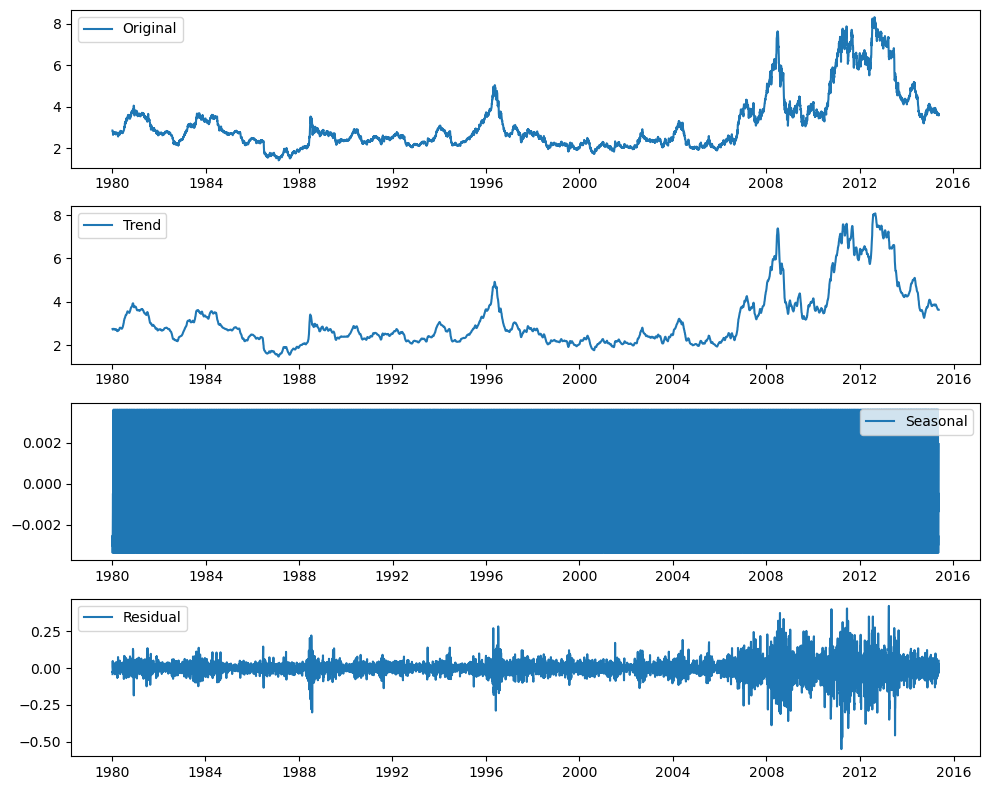

In [7]:

# Decompose the time series
decomposition = seasonal_decompose(train['value'], model='additive', period=12)

# Plot the decomposition
plt.figure(figsize=(10, 8))

# Original time series
plt.subplot(411)
plt.plot(train.index, train['value'], label='Original')
plt.legend()

# Trend component
plt.subplot(412)
plt.plot(train.index, decomposition.trend, label='Trend')
plt.legend()

# Seasonal component
plt.subplot(413)
plt.plot(train.index, decomposition.seasonal, label='Seasonal')
plt.legend()

# Residual component
plt.subplot(414)
plt.plot(train.index, decomposition.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


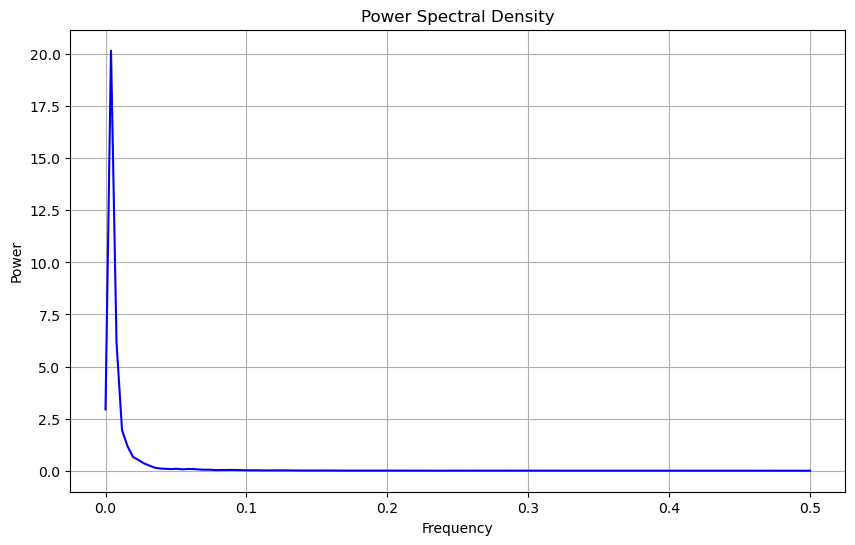

In [8]:
# Compute the power spectral density (PSD) using Welch's method
frequencies, psd = welch(data['value'])

# Plot the spectral density graph
plt.figure(figsize=(10, 6))
plt.plot(frequencies, psd, color='blue')
plt.title('Power Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.show()

In [9]:
results = adfuller(data['value'])
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

ADF Statistic: -2.665160
p-value: 0.080264


In [10]:
kpss_stat, p_value, lags, critical_values = kpss(data['value'])

# Print the results
print(f'KPSS Statistic: {kpss_stat}')
print(f'p-value: {p_value}')
print(f'Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Interpret the results
if p_value < 0.05:
    print('The time series is non-stationary (reject null hypothesis)')
else:
    print('The time series is stationary (fail to reject null hypothesis)')

KPSS Statistic: 7.781342333766564
p-value: 0.01
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
The time series is non-stationary (reject null hypothesis)


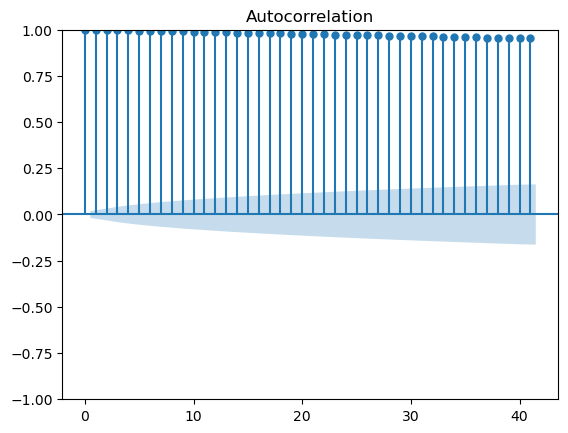

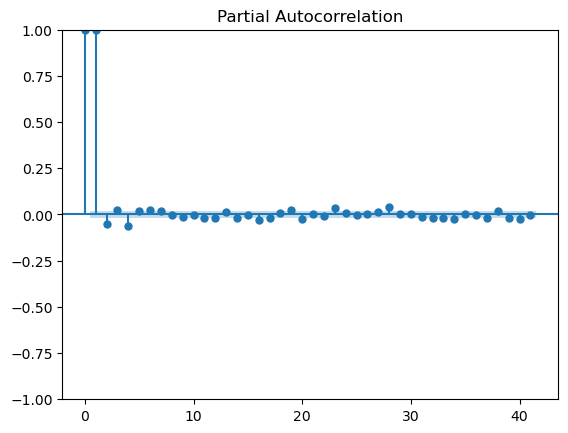

In [11]:
plot_acf(data['value'])
plot_pacf(data['value'])
plt.show()

In [12]:
y_train = train['value']
# Fit auto_arima to find the best ARIMA model
model = auto_arima(y_train, start_p=1, start_q=1,
                    max_p=5, max_q=5, m=12,
                    start_P=0, seasonal=True,
                    d=1, D=1, trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)



# Print the summary of the best model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=12.98 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-19011.606, Time=0.26 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-21723.239, Time=3.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=11.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-19058.801, Time=0.21 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-22943.727, Time=5.82 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=28.73 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=11.83 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-22870.682, Time=1.97 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-22945.937, Time=7.04 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-21724.153, Time=3.01 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=48.05 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=15.55 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-22945.828, Time=15.77 sec
 ARIMA(2,1,1)(2,1,0)[12]  

In [13]:
y_true = test['value']
forecast = model.predict(n_periods=len(test))
# Ensure forecast is a DataFrame with the same structure as y_true
forecast_df = pd.DataFrame(forecast, index=y_true.index, columns=['value'])

mse = MSE(y_true, forecast)
mae = MAE(y_true, forecast)

print('MSE:', mse)
print('MAE:', mae)

MSE: 97.38866053247955
MAE: 8.357386847412343


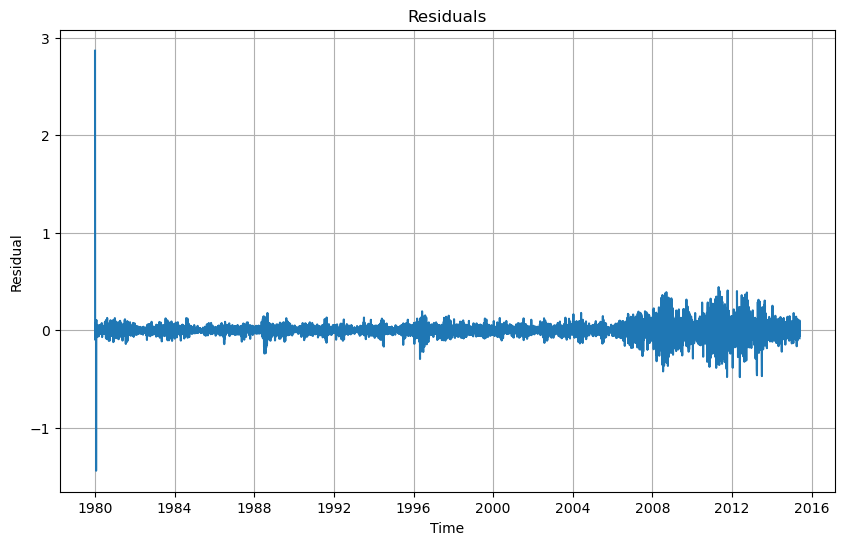

In [14]:
resids = model.resid()
# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(resids)
plt.title('Residuals')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

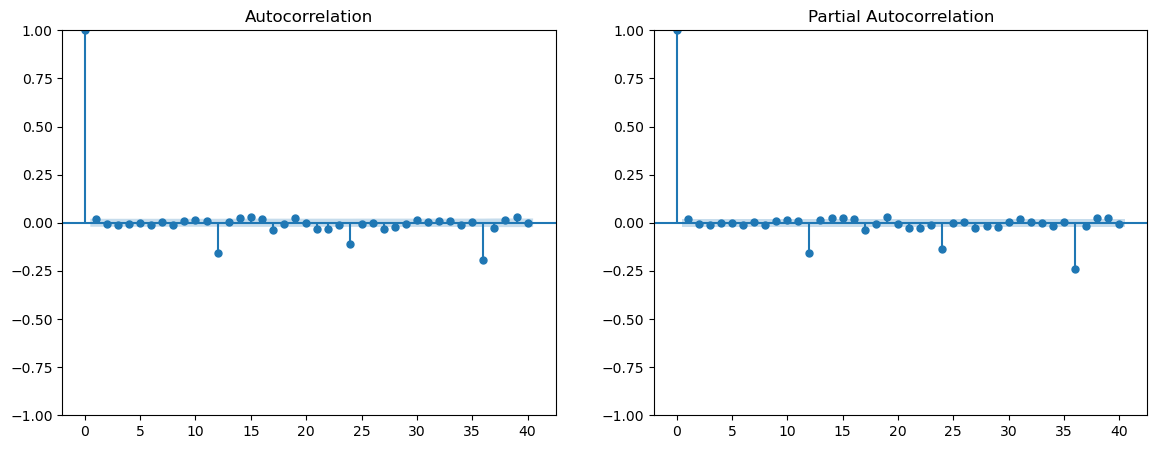

In [15]:
# Plot ACF and PACF of residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(resids, ax=axes[0])
plot_pacf(resids, ax=axes[1])
plt.show()

In [16]:
forecast_steps = 30
forecast = model.predict(n_periods=forecast_steps)
##forecast_values = forecast.predicted_mean
forecast_index = np.arange(len(y_train), len(y_train) + forecast_steps)
print(forecast)

8924    3.580572
8925    3.578603
8926    3.557145
8927    3.525781
8928    3.515230
8929    3.532774
8930    3.511941
8931    3.529413
8932    3.511599
8933    3.501186
8934    3.534238
8935    3.524912
8936    3.483385
8937    3.485929
8938    3.464530
8939    3.433244
8940    3.422585
8941    3.449529
8942    3.448887
8943    3.460009
8944    3.426093
8945    3.410232
8946    3.441684
8947    3.438166
8948    3.399312
8949    3.405234
8950    3.382333
8951    3.364676
8952    3.362554
8953    3.398055
dtype: float64


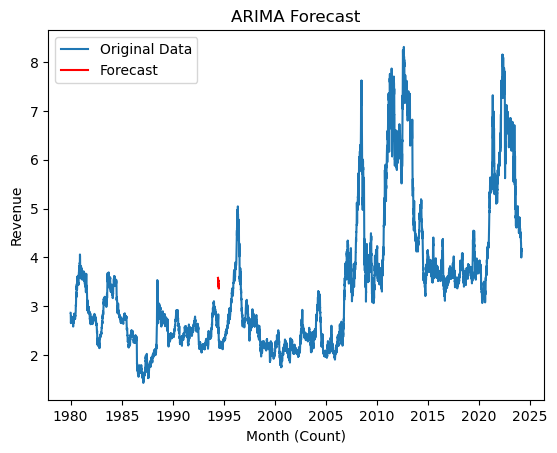

In [17]:
plt.plot(data.index, data.values, label='Original Data')

plt.plot(forecast_index, forecast, label='Forecast', color='red')

plt.title('ARIMA Forecast')
plt.xlabel('Month (Count)')
plt.ylabel('Revenue')
plt.legend()
plt.show()

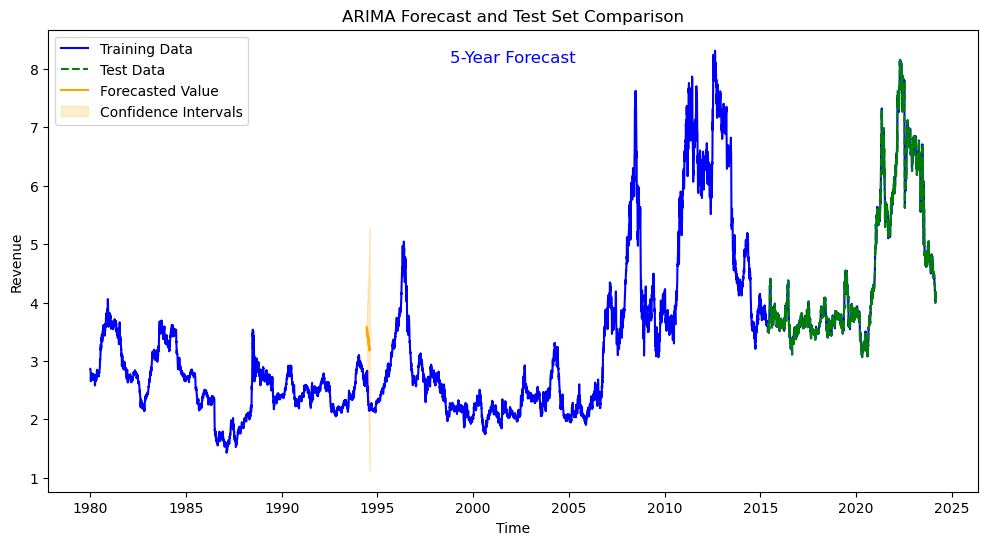

In [20]:
# Define the number of forecast steps (assuming monthly data)
forecast_years = 5
forecast_steps = forecast_years * 12

# Generate the forecast
forecast, confidence_intervals = model.predict(n_periods=forecast_steps, return_conf_int=True)

# Plotting the original series, forecast, confidence intervals, and test set
plt.figure(figsize=(12, 6))

# Plot actual revenue
plt.plot(data.index, data['value'], label='Training Data', color='blue')

# Plot test set
plt.plot(test.index, test['value'], label='Test Data', color='green', linestyle='--')

# Plot forecasted revenue
plt.plot(forecast.index, forecast, label='Forecasted Value', color='orange')

# Fill between confidence intervals
plt.fill_between(forecast.index, confidence_intervals[:, 0], confidence_intervals[:, 1], color='orange', alpha=0.2, label='Confidence Intervals')

# Annotate the plot with key information
plt.title('ARIMA Forecast and Test Set Comparison')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.legend()

# Add annotations
plt.annotate(f"5-Year Forecast", xy=(0.5, 0.93), xycoords='axes fraction', ha='center', fontsize=12, color='blue')

plt.show()
